In [23]:
from glob import glob
import re
import string
import funcy as fp
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD

In [3]:
before = pickle.load( open( "./Data/before.pkl", "rb" ) )

In [13]:
before = before.dropna()

In [34]:
before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16940 entries, 0 to 17134
Data columns (total 2 columns):
Publish Date    16940 non-null datetime64[ns]
clean           16940 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 397.0+ KB


In [35]:
text = before['clean']

In [28]:
import spacy
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [29]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nborders/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [31]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nborders/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
stop_words = ['would', 'could', 'might', 'season', 'think', 'one', 'watch', 'episode', 'something', 'theory', 'maybe',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even']

In [106]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [108]:
import random
text_data = []
for line in text:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        text_data.append(tokens)

In [109]:
text_data = [x for x in text_data if x != []]

In [112]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [113]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [82]:
import pickle
pickle.dump(corpus, open('corpus_before.pkl', 'wb'))
dictionary.save('dictionary_before.gensim')

In [116]:
import gensim
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model4_before.gensim')

In [117]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.015*"coming" + 0.010*"morello" + 0.010*"yeats" + 0.010*"second" + 0.010*"throne" + 0.006*"character" + 0.006*"spiral" + 0.006*"revelation" + 0.006*"george" + 0.006*"castle"')
(1, '0.018*"first" + 0.008*"realm" + 0.007*"people" + 0.007*"cersei" + 0.007*"tyrion" + 0.007*"monthly" + 0.006*"better" + 0.006*"theory" + 0.006*"control" + 0.006*"vary"')
(2, '0.013*"night" + 0.012*"house" + 0.012*"premiere" + 0.009*"people" + 0.007*"throne" + 0.006*"episode" + 0.006*"actually" + 0.006*"dragon" + 0.006*"ending" + 0.005*"series"')
(3, '0.016*"dothraki" + 0.016*"daenerys" + 0.012*"drogo" + 0.011*"eroeh" + 0.010*"mirri" + 0.010*"jorah" + 0.009*"death" + 0.007*"passion" + 0.006*"perhaps" + 0.006*"price"')


In [ ]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [118]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [121]:
corpus_cloud = ' '.join(before['clean'])

In [123]:
STOPWORDS.update(['would', 'could', 'might', 'season', 'think', 'one', 'watch', 'episode', 'something', 'theory', 'maybe',
             'scene', 'anyone', 'really', 'still', 'anyone', 'already', 'anything', 'never', 'everyone', 'even'])

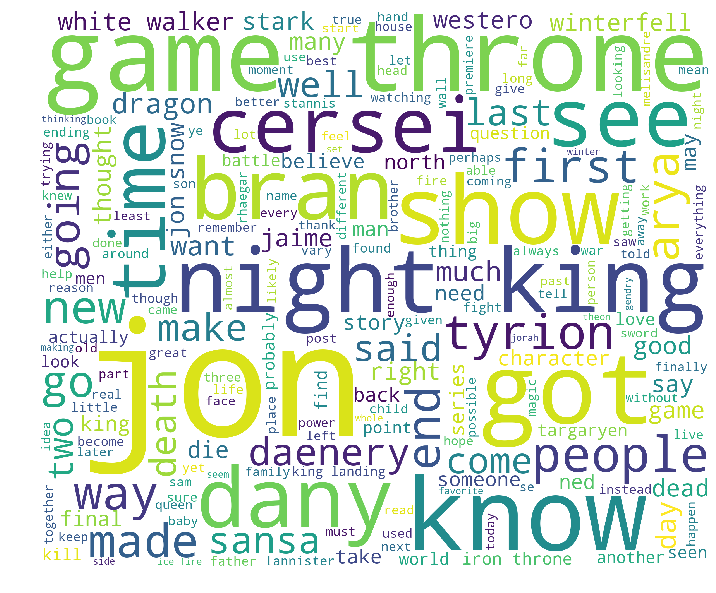

In [124]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(corpus_cloud)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [129]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.features import ParallelCoordinates

In [133]:
import os
from sklearn.datasets.base import Bunch

def load_corpus(path):
    """
    Loads and wrangles the passed in text corpus by path.
    """

    # Check if the data exists, otherwise download or raise
    if not os.path.exists(path):
        raise ValueError((
            "'{}' dataset has not been downloaded, "
            "use the yellowbrick.download module to fetch datasets"
        ).format(path))

    # Read the directories in the directory as the categories.
    categories = [
        cat for cat in os.listdir(path)
        if os.path.isdir(os.path.join(path, cat))
    ]

    files  = [] # holds the file names relative to the root
    data   = [] # holds the text read from the file
    target = [] # holds the string of the category

    # Load the data from the files in the corpus
    for cat in categories:
        for name in os.listdir(os.path.join(path, cat)):
            files.append(os.path.join(path, cat, name))
            target.append(cat)

            with open(os.path.join(path, cat, name), 'r') as f:
                data.append(f.read())


    # Return the data bunch for use similar to the newsgroups example
    return Bunch(
        categories=categories,
        files=files,
        data=data,
        target=target,
    )


In [136]:
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(before['clean'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


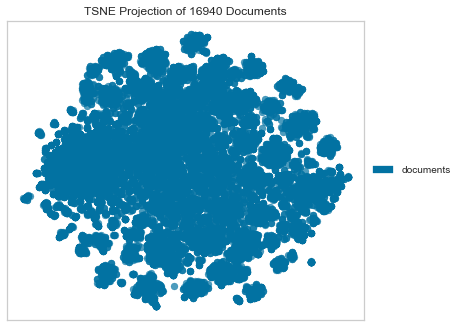

In [137]:
tsne = TSNEVisualizer(labels=["documents"])
tsne.fit(docs)
tsne.poof()